In [1]:
import numpy as np
import matplotlib as mpl
# %matplotlib inline

import pandas as pd

import json
import glob
import os

from networkit import *

In [20]:
def plot_and_save(df, name, kind='line', xlabel=None, ylabel=None, **kwargs):
    ax = df.plot(kind=kind, **kwargs)
    
    if xlabel != None:
        ax.set_xlabel(xlabel)
    if ylabel != None:
        ax.set_ylabel(ylabel)
    
    ax.legend().set_visible(False)
    mpl.pyplot.savefig("../../dist-thrill-cluster/plots/" + name + "_no_legend.png", dpi=300)
    ax.legend().set_visible(True)
    mpl.pyplot.savefig("../../dist-thrill-cluster/plots/" + name + ".png", dpi=300)
    
    df.to_csv("../../dist-thrill-cluster/plots/" + name + ".csv")

In [2]:
data = {}

for path in glob.glob(os.path.expanduser("/amd.home/home/i11/zeitz/ma/data/results/paper/weak_scaling2/*.json")) + glob.glob(os.path.expanduser("/amd.home/home/i11/zeitz/ma/data/results/paper/weak_scaling_quality/*.json")):
  for typename, items in json.load(open(path)).items():
    if typename in data:
      data[typename].update(items)
    else:
      data[typename] = items

frames = { typename: pd.DataFrame.from_dict(items, orient='index') for typename, items in data.items() }

In [3]:
dlslm_label = 'DSLM-Mod'
dlslm_me_label = 'DSLM-Map'
seq_postfix = ' w. Seq.'
no_contraction_postfix = ' w/o Contraction'
dlslm_ws_label = dlslm_label + seq_postfix
dlslm_nc_label = dlslm_label + no_contraction_postfix

algo_name_mapping = {
    'synchronous local moving with map equation': dlslm_me_label,
    'synchronous local moving with modularity': dlslm_label
}

frames['algorithm_run'].replace({ 'algorithm': algo_name_mapping }, inplace=True)

frames['algorithm_run']['algorithm'] += frames['algorithm_run'].merge(frames['program_run'], left_on='program_run_id', right_index=True, how='left')['switch_to_seq'].map({ False: '', True: seq_postfix, np.NaN: '' })
frames['algorithm_run']['algorithm'] += frames['algorithm_run'].merge(frames['program_run'], left_on='program_run_id', right_index=True, how='left')['contraction'].map({ False: no_contraction_postfix, True: '', np.NaN: '' })

In [4]:
def siml(x):
    files = sorted(glob.glob(os.path.expanduser("/algoDaten/zeitz/graphs/LFR/part" + x['graph'][33:])))
    ground_truth = community.BinaryEdgeListPartitionReader(0, 4).read(files)
    
    files = sorted(glob.glob(os.path.expanduser('/amd.home/home/i11/zeitz/ma/data/results/paper/weak_scaling2/' + x['path'].replace('@@@@-#####', '*'))))
    if not files:
        files = sorted(glob.glob(os.path.expanduser('/amd.home/home/i11/zeitz/ma/data/results/paper/weak_scaling_quality/' + x['path'].replace('@@@@-#####', '*'))))
    clustering = community.BinaryEdgeListPartitionReader(0, 4).read(files)
        
    g = graph.Graph(ground_truth.numberOfElements())
    nmi = 1.0 - community.NMIDistance().getDissimilarity(g, clustering, ground_truth)
    ari = 1.0 - community.AdjustedRandMeasure().getDissimilarity(g, clustering, ground_truth)
    return pd.Series([nmi, ari, clustering.numberOfSubsets()])
    
frames['clustering'][['NMI', 'ARI', 'cluster_count']] = frames['clustering'] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .apply(siml, axis=1)

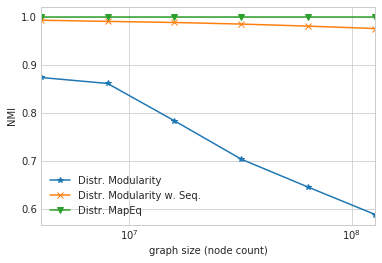

In [22]:
df = frames['clustering'] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .groupby(['node_count', 'algorithm'])['NMI'].mean().to_frame().unstack() \
    ["NMI"][[dlslm_label, dlslm_nc_label, dlslm_me_label]]

plot_and_save(df, "weak_scaling_NMI", ylabel="NMI", xlabel="graph size (node count)", logx=True, style=['-*', '-x', '-v'])

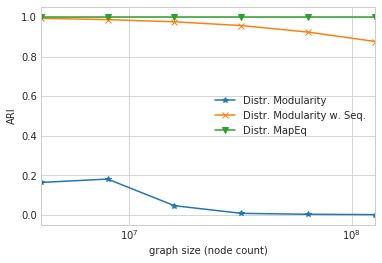

In [23]:
df = frames['clustering'] \
    .merge(frames['algorithm_run'], left_on='algorithm_run_id', right_index=True) \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .groupby(['node_count', 'algorithm'])['ARI'].mean().to_frame().unstack() \
    ["ARI"][[dlslm_label, dlslm_nc_label, dlslm_me_label]]

plot_and_save(df, "weak_scaling_ARI", ylabel="ARI", xlabel="graph size (node count)", logx=True, style=['-*', '-x', '-v'])